# Autoencoders

In this assignment, we will look at autoencoders and compare their performance with an autoencoder-based PCA model. For this, we will continue to use the MNIST dataset that we have seen in the previous assignments. 

As usual, the structure of the code is given to you, and you need to fill in the parts corresponding to the questions below. 

__PART A__: In this part we will build three models: an autoencoder-based PCA, a 2-layer and a 3-layer autoencoder. We will then train and test these models on the MNIST dataset and compare their performance visually as well as by ccomputing the test set recontruction error. 
- <a href='#question 1'>Question 1</a> Autoencoder-based PCA: implement an autoencoder-based PCA model formed of two linear layers, using a structure similar to the 2-layer autoencoder model. 
- <a href='#question 2'>Question 2</a> 2-layer autoencoder: Use different number of nodes (e.g.\[128,16\]), in hidden layers and compare the results. 
- <a href='#question 3'>Question 3</a> 3-layer: after reading the basic autoencoder provided as an example, build a 3-layer autoencoder. Use different number of nodes (e.g.\[128,64,16\]), in hidden layers and compare the results. 
  
__PART B__: In this part we will interpolate between two images in the latent space. This is done by first obtaining the encoded images:

\begin{align}
latent\_1 = encoder(image\_1) 
\end{align}

\begin{align}
latent\_2 = encoder(image\_2)
\end{align}

and then generating the new interpolated image using the following equation:

\begin{align}
interpolated\_image\_\lambda = decoder[\lambda* latent\_1 + (1- \lambda) * latent\_2]
\end{align}

We will do this using the PCA model and then the autoencoder model and look at the differences between the two interpolations. Then, we need to get the image space representation and to verify that the interpolation generated using the 3-layer autoencoder is better.
- <a href='#question 1B'>Question 1</a> Fill interpolation() function in orde to <br>
 1.1. Get the latent space representation. <br>
 1.2. Interpolate between two images.<br>
 1.3. Get the image space represantion.
- <a href='#question 2B'>Question 2</a> Interpolate between an image corresponding to digit 1 and an image corresponding to digit 7 using the latent space representation obtained using the autoencoder-based PCA. Interpolate between an image corresponding to digit 1 and an image corresponding to digit 7 using the latent space representation obtained using the 3-layer autoencoder. Repeat the same procedure interpolating between images corresponding to digits 4 and 8.
   


In [ ]:
# Import libraries

import os
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as dset
from torchvision.utils import save_image

In [ ]:
# Import dataset
batch_size = 128

# Convert the data to Tensor and normalise by the mean and std  of the data set
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

# Import and normalize the train set in mini-batches 
train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_set_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                              shuffle=True)

# Import and normalize the test set in mini-batches
test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
test_set_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                              shuffle=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#### Visualise
Visualise examples of the images from the dataset. 

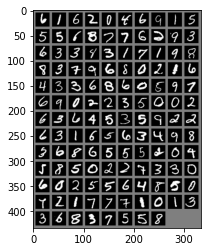

In [ ]:
# Import libraries for visualising
import matplotlib.pyplot as plt
import numpy as np

# Load a batch of training images for visualising
data_iterator = iter(train_set_loader)
images, labels = data_iterator.next()

# Create function for visualisation
def show_image(img):
    # revert the normalisation for displaying the images in their original form
    img = img * 0.5 + 0.5
    # Convert to numpy for visualisation
    npimg = img.numpy()
    # Plot each image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# Plot images as a grid using the 'make_grid' function
show_image(torchvision.utils.make_grid(images,10,5))
plt.show()

## PART A: 

## Models
In this section we will implements three models as three different classes:

1. An autoencoder-based PCA. 
2. A 2-layer autoencoder.
3. A 3-layer autoencoder.


<a id='question 1'></a>

#### 1. Autoencoder-based PCA model
Build an autoencoder-based PCA model. This will be made of two linear layers. The first linear layer is the encoder part. It receives as an input the image and has an output of shape num_hidden_1, where num_hidden_1 the number of hidden units in layer _L1_ . The second linear layer is the decoder and has an output of the same shape as the images in the dataset, since its role is to reconstruct the image. 

In [ ]:
class autoencoder_PCA(nn.Module):
    def __init__(self,num_in,num_hidden_1,num_out):
        super(autoencoder_PCA, self).__init__()
        ####### Question 1 #######
        # The layers of the encoder
        self.encoder = nn.Linear(num_in,num_hidden_1)
        # The layers of the decoder   
        self.decoder = nn.Linear(num_hidden_1,num_out)
        ####### End Question 1 

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### 2. 2-layer autoencoder model
This model is made of two parts:

a. __the encoder__: a layer that takes as an input the image and has an output of shape num_hidden_1 and a __ReLU__ activation function. A second layer that has an output of shape num_hidden_2 and no activation function.

b. __the decoder__: this takes as an input the output of the encoder and has the same structure as a decoder, but in inverse order (the mirror image of the decoder). Additionally, the decoder applies a __tanh__ activation function to the final layer. 

This function is already given to you as an example of a basic autoencoder.

In [ ]:
class layer_2_autoencoder(nn.Module):
    def __init__(self,num_in,num_hidden_1,num_hidden_2,num_out):
        super(layer_2_autoencoder, self).__init__()
        # The layers of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(num_in, num_hidden_1),
            nn.ReLU(True),
            nn.Linear(num_hidden_1, num_hidden_2))
        # The layers of the decoder   
        self.decoder = nn.Sequential(
            nn.Linear(num_hidden_2, num_hidden_1),
            nn.ReLU(True), 
            nn.Linear(num_hidden_1, num_out), 
            nn.Tanh())
        
    # The forward pass    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


#### 2. 3-layer model
This model is similar to the previous one, but with a deeper structure:

a. __the encoder__: a layer that takes as an input the image and has an output of shape num_hidden_1 and a __ReLU__ activation function. A second layer that has an output of shape num_hidden_2 and a __ReLU__ activation function. A final linear layer with output of shape num_hidden_3 and no activation function

b. __the decoder__: this takes as an input the output of the encoder and has the same structure as a decoder, but in inverse order (the mirror image of the decoder). Additionally, the decoder applies a __tanh__ activation function to the final layer. 


In [ ]:
class layer_3_autoencoder(nn.Module):
    def __init__(self,num_in,num_hidden_1,num_hidden_2,num_hidden_3,num_out):
        super(layer_3_autoencoder, self).__init__()
        ####### Question 3 #######
        # The layers of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(num_in, num_hidden_1),
            nn.ReLU(True),
            nn.Linear(num_hidden_1, num_hidden_2),
            nn.ReLU(True),
            nn.Linear(num_hidden_2,num_hidden_3))
        # The layers of the decoder   
        self.decoder = nn.Sequential(
            nn.Linear(num_hidden_3, num_hidden_2),
            nn.ReLU(True), 
            nn.Linear(num_hidden_2, num_hidden_1), 
            nn.ReLU(True), 
            nn.Linear(num_hidden_1, num_out), 
            nn.Tanh())
        ####### End Question 3 #######
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Train and test the models

#### Train function

Now that we have build the models, let's define a function which performs the training. this function has the following parameters: the train set, the batch size, the number of epochs for which to perform the trainig, the learning rate, and the model to train. 

In [ ]:
def train(train_set, batch_size, num_epochs, learning_rate, model):

    no_batches = int(np.round((len(train_set) / batch_size)))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

    losses = []
    for epoch in range(num_epochs):
        train_loss = 0
        for data in train_set_loader:
            img, _ = data
            img = img.view(img.size(0), -1)
            img = Variable(img)
            
            # =================== forward pass =====================
            output = model(img)
            loss = criterion(output, img)
            
            # =================== backward pass ====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.data
            
            # =================== log ========================
        print('====> Epoch: {} Average loss: {:.4f}'.format(
               epoch, train_loss / no_batches))
        losses.append(train_loss / no_batches)   
    return losses

#### Test function
Similarly to the train function, build a test function that evaluates the performance of the models on the test set 

In [ ]:
def evaluate_test(test_set, test_set_loader, batch_size, model):
    
    test_loss = 0
    criterion = nn.MSELoss()
    test_no_batches = np.round(int(len(test_set)/batch_size))
    
    for data in test_set_loader:
            img, _ = data
            img = img.view(img.size(0), -1)
            img = Variable(img)
            
            # =================== forward pass =====================
            output = model(img)
            loss = criterion(output, img)
            test_loss += loss.data
            
        # =================== log ========================
    test_loss = test_loss/test_no_batches
    print('====> Test loss: {:.4f}'.format(test_loss))
    return test_loss

Now that we have written the train and test functions, let's train and then compare the reconstruction error on the train and test set of the three models. For each model, plot the training error. 

### 1. Autoencoder-based PCA model
Train and test an autoencoder-based PCA with num_hidden_1=16 hidden units in the hidden layer.

====> Epoch: 0 Average loss: 0.2920
====> Epoch: 1 Average loss: 0.1567
====> Epoch: 2 Average loss: 0.1305
====> Epoch: 3 Average loss: 0.1199
====> Epoch: 4 Average loss: 0.1160
====> Epoch: 5 Average loss: 0.1149
====> Epoch: 6 Average loss: 0.1145
====> Epoch: 7 Average loss: 0.1143
====> Epoch: 8 Average loss: 0.1142
====> Epoch: 9 Average loss: 0.1139
====> Epoch: 10 Average loss: 0.1137
====> Epoch: 11 Average loss: 0.1136
====> Epoch: 12 Average loss: 0.1134
====> Epoch: 13 Average loss: 0.1133
====> Epoch: 14 Average loss: 0.1132
====> Epoch: 15 Average loss: 0.1131
====> Epoch: 16 Average loss: 0.1130
====> Epoch: 17 Average loss: 0.1129
====> Epoch: 18 Average loss: 0.1129
====> Epoch: 19 Average loss: 0.1128
====> Epoch: 20 Average loss: 0.1127
====> Epoch: 21 Average loss: 0.1126
====> Epoch: 22 Average loss: 0.1125
====> Epoch: 23 Average loss: 0.1124
====> Epoch: 24 Average loss: 0.1122
====> Epoch: 25 Average loss: 0.1121
====> Epoch: 26 Average loss: 0.1119
====> Epoch

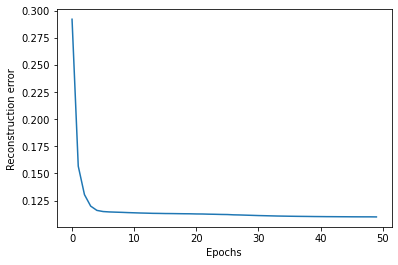

====> Test loss: 0.1098


In [ ]:
#define the model
num_input=28*28
num_hidden_1=16
num_output=28*28
model1 = autoencoder_PCA(num_input,num_hidden_1,num_output)

#train the model
model1_loss_train = train(train_set= train_set, batch_size = 128, num_epochs = 50, learning_rate=1e-3, model = model1)
# number of epochs reduced for faster times

# Plot the training error
fig = plt.figure()
plt.plot(model1_loss_train)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

# Calculate the loss in test set
model1_loss_test= evaluate_test(test_set = test_set, test_set_loader=  test_set_loader,batch_size = 128, model=model1)

### 2. 2-layer autoencoder
Train and test an autoencoder-based PCA with num_hidden_1=32 and num_hidden_2=16 hidden units in the hidden layers.

====> Epoch: 0 Average loss: 0.2265
====> Epoch: 1 Average loss: 0.1168
====> Epoch: 2 Average loss: 0.1025
====> Epoch: 3 Average loss: 0.0967
====> Epoch: 4 Average loss: 0.0916
====> Epoch: 5 Average loss: 0.0873
====> Epoch: 6 Average loss: 0.0830
====> Epoch: 7 Average loss: 0.0815
====> Epoch: 8 Average loss: 0.0806
====> Epoch: 9 Average loss: 0.0798
====> Epoch: 10 Average loss: 0.0792
====> Epoch: 11 Average loss: 0.0786
====> Epoch: 12 Average loss: 0.0782
====> Epoch: 13 Average loss: 0.0777
====> Epoch: 14 Average loss: 0.0773
====> Epoch: 15 Average loss: 0.0769
====> Epoch: 16 Average loss: 0.0765
====> Epoch: 17 Average loss: 0.0762
====> Epoch: 18 Average loss: 0.0759
====> Epoch: 19 Average loss: 0.0756
====> Epoch: 20 Average loss: 0.0754
====> Epoch: 21 Average loss: 0.0752
====> Epoch: 22 Average loss: 0.0750
====> Epoch: 23 Average loss: 0.0749
====> Epoch: 24 Average loss: 0.0747
====> Epoch: 25 Average loss: 0.0746
====> Epoch: 26 Average loss: 0.0744
====> Epoch

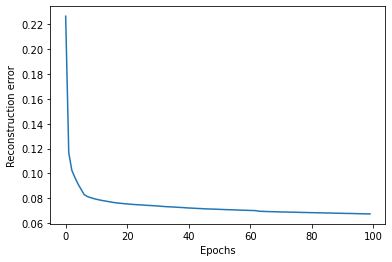

====> Test loss: 0.0669


In [ ]:
#define the model
num_input=28*28
num_hidden_1=32
num_hidden_2=16
num_output=28*28

model2 = layer_2_autoencoder(num_input,num_hidden_1,num_hidden_2,num_output)

#train the model
model2_loss_train = train(train_set= train_set, batch_size = 128, num_epochs = 100, learning_rate=1e-3, model = model2)

# Plot the error 
fig = plt.figure()
plt.plot(model2_loss_train)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

#calculate the loss in test set
model2_loss_test= evaluate_test(test_set = test_set, test_set_loader=  test_set_loader,batch_size = 128, model=model2)

<a id='question 2'></a>

Use different number of nodes (e.g.\[128,16\]), in hidden layers and compare the results.

====> Epoch: 0 Average loss: 0.1409
====> Epoch: 1 Average loss: 0.0795
====> Epoch: 2 Average loss: 0.0721
====> Epoch: 3 Average loss: 0.0678
====> Epoch: 4 Average loss: 0.0646
====> Epoch: 5 Average loss: 0.0620
====> Epoch: 6 Average loss: 0.0600
====> Epoch: 7 Average loss: 0.0585
====> Epoch: 8 Average loss: 0.0572
====> Epoch: 9 Average loss: 0.0562
====> Epoch: 10 Average loss: 0.0553
====> Epoch: 11 Average loss: 0.0545
====> Epoch: 12 Average loss: 0.0538
====> Epoch: 13 Average loss: 0.0531
====> Epoch: 14 Average loss: 0.0525
====> Epoch: 15 Average loss: 0.0520
====> Epoch: 16 Average loss: 0.0514
====> Epoch: 17 Average loss: 0.0511
====> Epoch: 18 Average loss: 0.0506
====> Epoch: 19 Average loss: 0.0503
====> Epoch: 20 Average loss: 0.0499
====> Epoch: 21 Average loss: 0.0496
====> Epoch: 22 Average loss: 0.0494
====> Epoch: 23 Average loss: 0.0491
====> Epoch: 24 Average loss: 0.0489
====> Epoch: 25 Average loss: 0.0487
====> Epoch: 26 Average loss: 0.0485
====> Epoch

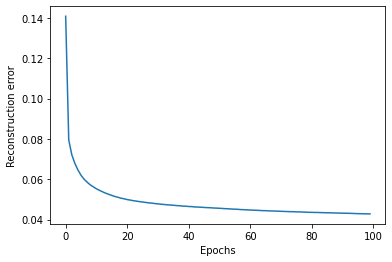

====> Test loss: 0.0427


In [ ]:
#define the model
####### Question 2 #######
num_input=28*28
num_hidden_1=128
num_hidden_2=16
num_output=28*28

model2 = layer_2_autoencoder(num_input,num_hidden_1,num_hidden_2,num_output)

#train the model
model2_loss_train = train(train_set= train_set, batch_size = 128, num_epochs = 100, learning_rate=1e-3, model = model2)

# Plot the error 
fig = plt.figure()
plt.plot(model2_loss_train)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

#calculate the loss in test set
model2_loss_test= evaluate_test(test_set = test_set, test_set_loader=  test_set_loader,batch_size = 128, model=model2)

####### End of Question 2 #######


### 3. 3-layer autoencoder
<a id='question 3'></a>


====> Epoch: 0 Average loss: 0.2193
====> Epoch: 1 Average loss: 0.1282
====> Epoch: 2 Average loss: 0.1066
====> Epoch: 3 Average loss: 0.0972
====> Epoch: 4 Average loss: 0.0927
====> Epoch: 5 Average loss: 0.0887
====> Epoch: 6 Average loss: 0.0852
====> Epoch: 7 Average loss: 0.0818
====> Epoch: 8 Average loss: 0.0790
====> Epoch: 9 Average loss: 0.0772
====> Epoch: 10 Average loss: 0.0756
====> Epoch: 11 Average loss: 0.0743
====> Epoch: 12 Average loss: 0.0731
====> Epoch: 13 Average loss: 0.0719
====> Epoch: 14 Average loss: 0.0707
====> Epoch: 15 Average loss: 0.0694
====> Epoch: 16 Average loss: 0.0683
====> Epoch: 17 Average loss: 0.0674
====> Epoch: 18 Average loss: 0.0667
====> Epoch: 19 Average loss: 0.0661
====> Epoch: 20 Average loss: 0.0655
====> Epoch: 21 Average loss: 0.0650
====> Epoch: 22 Average loss: 0.0645
====> Epoch: 23 Average loss: 0.0641
====> Epoch: 24 Average loss: 0.0637
====> Epoch: 25 Average loss: 0.0632
====> Epoch: 26 Average loss: 0.0629
====> Epoch

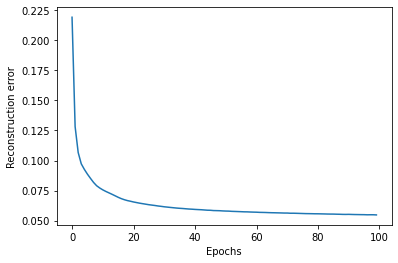

====> Test loss: 0.0543


In [ ]:
#define the model
num_input=28*28
num_hidden_1=64
num_hidden_2=32
num_hidden_3=16
num_output=28*28

model3 = layer_3_autoencoder(num_input,num_hidden_1,num_hidden_2,num_hidden_3,num_output)

#train the model
model3_loss_train = train(train_set= train_set, batch_size = 128, num_epochs = 100, learning_rate=1e-3, model = model3)

# Plot the error 
fig = plt.figure()
plt.plot(model3_loss_train)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

#calculate the loss in test set
model3_loss_test= evaluate_test(test_set = test_set, test_set_loader=  test_set_loader,batch_size = 128, model=model3)

In [ ]:
# NOTE:
# I didnt have the time to do the this last training as it takes very long.
# It should be very similar to the one above as they work in the same way just
# different number of channels in the hidden variables.
# The training works, you can try it.

####### Question 3 #######
#define the model
num_input=28*28
num_hidden_1=128
num_hidden_2=32
num_hidden_3=8
num_output=28*28

model3 = layer_3_autoencoder(num_input,num_hidden_1,num_hidden_2,num_hidden_3,num_output)

#train the model
model3_loss_train = train(train_set= train_set, batch_size = 128, num_epochs = 100, learning_rate=1e-3, model = model3)

# Plot the error 
fig = plt.figure()
plt.plot(model3_loss_train)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

#calculate the loss in test set
model3_loss_test= evaluate_test(test_set = test_set, test_set_loader=  test_set_loader,batch_size = 128, model=model3)
####### End of Question 3 #######


### Visualise the reconstructions obtained from the three models

In [ ]:
data_iterator = iter(test_set_loader)
images, labels = data_iterator.next()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

def visualise_output(images, model):
    data =images
    img= data
    img = img.view(img.size(0), -1)
    img = Variable(img)
    out = model(img)
    pic = out.data.view(out.data.size(0), 1, 28, 28)
    pic = pic * 0.5 + 0.5
    np_pic = torchvision.utils.make_grid(pic[1:50], 10, 5).numpy()
    plt.imshow(np.transpose(np_pic, (1, 2, 0)))
    plt.show()

Original images


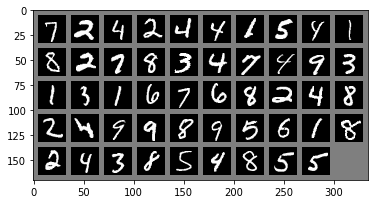

PCA based autoencoder reconstruction:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


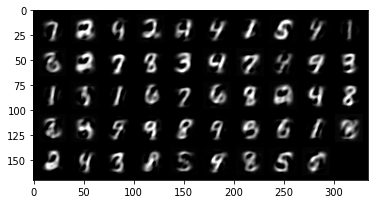

2-layer autoencoder reconstruction:


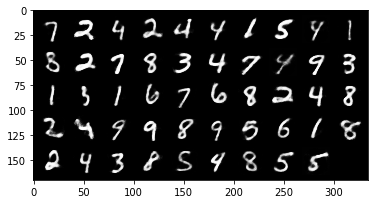

3-layer autoencoder reconstruction:


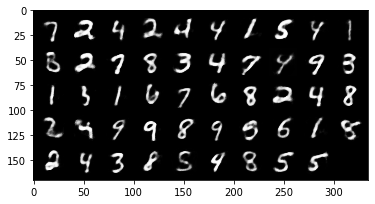

In [ ]:
# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the first model
print('PCA based autoencoder reconstruction:')
visualise_output(images, model1)

# Reconstruct and visualise the images using the second model
print('2-layer autoencoder reconstruction:')
visualise_output(images, model2)

# Reconstruct and visualise the images using the third model
print('3-layer autoencoder reconstruction:')
visualise_output(images, model3)

## Part B

In this part of the assignment we need to interpolate between two images using the latent space representation obtained by the autoencoder-based PCA and the 3-layer autoencoder and subsequently to verify that the interpolation generated using the 3-layer autoencoder is better. 

In [ ]:
#Extract images to apply interpolation 
one = []
four = []
seven = []
eight = []

for i in range(len(train_set)):
    if (train_set[i][1]==1):
        one.append(train_set[i])
    
    if (train_set[i][1]==4):
        four.append(train_set[i])

    if (train_set[i][1]==7):
        seven.append(train_set[i])
    
    if (train_set[i][1]==8):
        eight.append(train_set[i])
    
img1= seven[0][0]
npimg = img1.numpy()
im7 = npimg.reshape(28, 28)

img2 = one[0][0]
npimg = img2.numpy()
im1 = npimg.reshape(28, 28)

img3 = four[0][0]
npimg = img3.numpy()
im4 = npimg.reshape(28, 28)

img4 = eight[0][0]
npimg = img4.numpy()
im8 = npimg.reshape(28, 28)
    

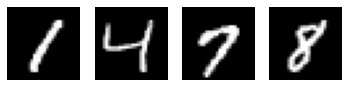

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(im1, cmap='gray')
ax1.axis('off')
ax2.imshow(im4, cmap='gray')
ax2.axis('off')
ax3.imshow(im7, cmap='gray')
ax3.axis('off')
ax4.imshow(im8, cmap='gray')
ax4.axis('off')
plt.show()

In [ ]:
sevens = torch.Tensor(seven[0][0])
ones = torch.Tensor(one[0][0])
fours = torch.Tensor(four[0][0])
eights = torch.Tensor(eight[0][0])

<a id='question 1B'></a>

Fill interpolation() function in orde to <br>
1.1. Get the latent space representation. <br>
1.2. Interpolate between two images using the following equation
\begin{align}
interpolated\_image\_\lambda = decoder[\lambda* latent\_1 + (1- \lambda) * latent\_2].
\end{align}
1.3. Get the image space represantion.

In [ ]:
def interpolation(lambda1, model, image1, image2):
    
    img1 = image1
    img1 = img1.view(img1.size(0), -1)
    img1 = Variable(img1)
    ############ Question 1 ############
    #Latent space interpretation of image1 
    latent_1 = model.encoder(img1)
    
    img2 = image2
    img2 = img2.view(img1.size(0), -1)
    img2 = Variable(img2)
    #Latent space interpretation of image2
    latent_2 = model.encoder(img2)
    
    #Interpolation of the two images
    inter_image_lat = lambda1*latent_1+(1-lambda1)*latent_2
    inter_image = model.decoder(inter_image_lat)
    
    return inter_image
    ############ END of question 1 ############
   

<a id='question 2B'></a>

Interpolation between digits _seven_ and _one_ using the autoencoder-based PCA.

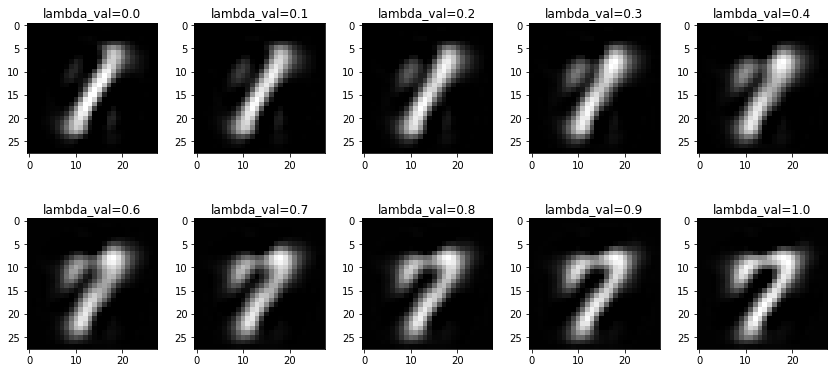

In [ ]:
############ Question 2 ############

lambda_range=np.linspace(0,1,10)


fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    image_lambda = interpolation(l, model1, sevens, ones)
   
    pic = to_img(image_lambda)
    image = pic.data.numpy()
    image = image.reshape(28,28)
   
    axs[ind].imshow(image, cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 


<a id='question 2B'></a>

Interpolation between digits _seven_ and _one_ using the 3-layer autoencoder.

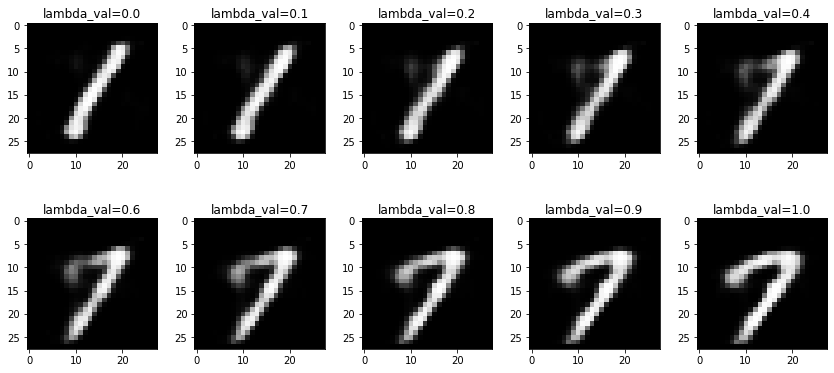

In [ ]:
############ Question 2 ############

lambda_range=np.linspace(0,1,10)


fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    image_lambda = interpolation(l, model3, sevens, ones)
   
    pic = to_img(image_lambda)
    image = pic.data.numpy()
    image = image.reshape(28,28)
   
    axs[ind].imshow(image, cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

<a id='question 2B'></a>
Interpolation between digits _four_ and _eight_ using the autoencoder-based PCA.


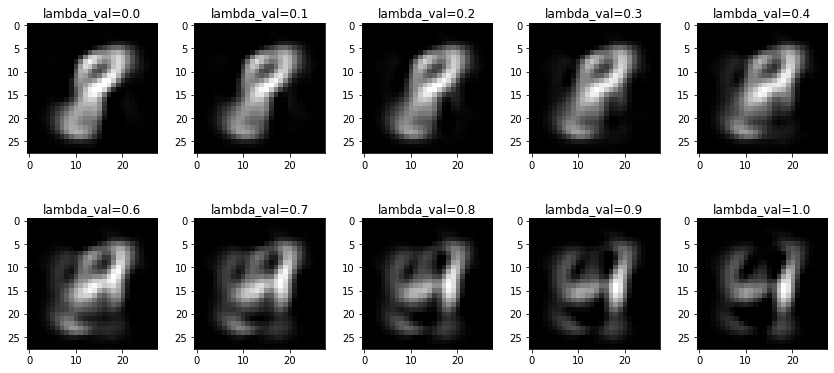

In [ ]:
############ Question 2 ############

lambda_range=np.linspace(0,1,10)


fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    image_lambda = interpolation(l, model1, fours, eights)
   
    pic = to_img(image_lambda)
    image = pic.data.numpy()
    image = image.reshape(28,28)
   
    axs[ind].imshow(image, cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 


<a id='question 2B'></a>

Interpolation between digits _four_ and _eight_ using the 3-layer autoencoder.

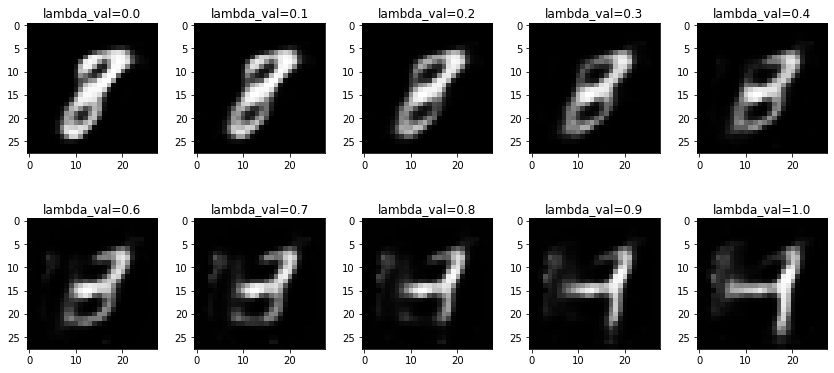

In [ ]:
############ Question 2 ############

lambda_range=np.linspace(0,1,10)


fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    image_lambda = interpolation(l, model3, fours, eights)
   
    pic = to_img(image_lambda)
    image = pic.data.numpy()
    image = image.reshape(28,28)
   
    axs[ind].imshow(image, cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 